Name: Write Your Name Here

In [5]:
#Dimitar Gjorgievski

Submission:

1- Run all cells (this is important, the results will remain there for us to look)

2- Download .ipynb

3- Submit your .ipynb on Gradescope

4- Double check your submitted file to make sure the submission is correct and it shows all the cell outputs


In [6]:
#Mounting Google Drive:
#After running this cell a popup window will appear and requesting to select your  Google account and give the access permission.
#You can either use your personal Google account or your UIC Google account.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#You need to change this path
path="/content/gdrive/MyDrive/cs412/Logistic Regression/"

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import re
import pandas as pd

Numpy is library for scientific computing in Python. It has efficient implementation of n-dimensional array (tensor) manupulations, which is useful for machine learning applications.

In [9]:
import numpy as np

We can convert a list into numpy array (tensor)  

In [10]:
b = [[1, 2, 4], [2, 6, 9]]
a = np.array(b)
a

array([[1, 2, 4],
       [2, 6, 9]])

We can check the dimensions of the array

In [11]:
a.shape

(2, 3)

We can apply simple arithmetic operation on all element of a tensor

In [12]:
a * 3

array([[ 3,  6, 12],
       [ 6, 18, 27]])

You can transpose a tensor
    

In [13]:
print(a.T.shape)
a.T

(3, 2)


array([[1, 2],
       [2, 6],
       [4, 9]])

You can apply aggregate functions on the whole tensor

In [14]:
np.sum(a)

24

or on one dimension of it

In [15]:
np.sum(a, axis=0)

array([ 3,  8, 13])

In [16]:
np.sum(a, axis=1)

array([ 7, 17])

We can do element-wise arithmetic operation on two tensors (of the same size)

In [17]:
c1 = np.array([[1, 2, 4], [2, 6, 9]])
c2 = np.array([[2, 3, 5], [1, 2, 1]])
c1 * c2

array([[ 2,  6, 20],
       [ 2, 12,  9]])

If you want to multiply all columns of a tensor by vector (for example if you want to multiply all data features by their lables) you need a trick. This multiplication shows up in calculating the gradients.

In [18]:
a = np.array([[1, 2, 4], [2, 6, 9]])
b = np.array([1,-1])
print(a)
print(b)


[[1 2 4]
 [2 6 9]]
[ 1 -1]


Here we want to multiply the first row of a by 1 and the second row of a by -1. Simply multiplying a by b does not work because a and b do not have the same dimension

In [19]:
a.T * b

array([[ 1, -2],
       [ 2, -6],
       [ 4, -9]])

To do this multiplication we first have to assume b has one column and then repeat the column of b with the number of columns in a. We use tile function to do that

In [20]:
b_repeat = np.tile(b,  (a.shape[1],1)).T
print(b_repeat.shape)
b_repeat

(2, 3)


array([[ 1,  1,  1],
       [-1, -1, -1]])

Now we can multiply each column of a by b:

In [21]:
a * b_repeat

array([[ 1,  2,  4],
       [-2, -6, -9]])

You can create inital random vector using numpy (using N(0,1)):

In [22]:
mu = 0 #mean
sigma = 1 #standard deviation
r = np.random.normal(mu,sigma, 1000) #draws 1000 samples from a normal distribution

We can apply functions on tensors

In [23]:
#implementation of Normal distribution
def normal(x, mu, sigma):
    return np.exp( -0.5 * ((x-mu)/sigma)**2)/np.sqrt(2.0*np.pi*sigma**2)

#probability of samples on the Normal distribution
probabilities = normal(r, mu, sigma)

Numpy has useful APIs for analysis. Here we plot the histogram of samples and also plot the probabilies to see if the samples follow the normal distribution.

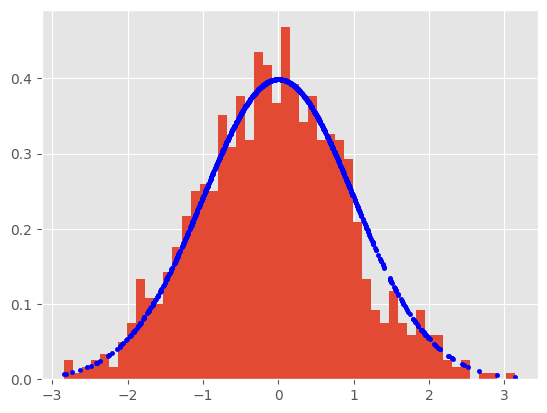

In [24]:
counts, bins = np.histogram(r,50,density=True)
plt.hist(bins[:-1], bins, weights=counts)
plt.scatter(r, probabilities, c='b', marker='.')

In [25]:
def read_data(filename):  #reading the filename
    f = open(filename, 'r') #open file for reading
    p = re.compile(',')
    xdata = []
    ydata = []
    header = f.readline().strip() #f; the file is used to get header section
    varnames = p.split(header) #get a list of the atttribute names
    namehash = {}
    for l in f: #go through rest of the file and put all the features in proper
        li = p.split(l.strip())
        xdata.append([float(x) for x in li[:-1]]) #add all the features to a list
        ydata.append(float(li[-1])) #add all the class variables to the list

    return np.array(xdata), np.array(ydata) #converting xdata into a matrix; converting ydata to a vector


Assuming our data is x is available in numpy we use numpy to implement logistic regression


In [26]:
(xtrain_whole, ytrain_whole) = read_data(path + 'spambase-train.csv') #training data
(xtest, ytest) = read_data(path + 'spambase-test.csv')  #test data

In [27]:
print("The shape of xtrain:", xtrain_whole.shape)
print("The shape of ytrain:", ytrain_whole.shape)
print("The shape of xtest:", xtest.shape)
print("The shape of ytest:", ytest.shape)

The shape of xtrain: (3601, 54)
The shape of ytrain: (3601,)
The shape of xtest: (1000, 54)
The shape of ytest: (1000,)


before training make we normalize the input data (features)

In [28]:
xmean = np.mean(xtrain_whole, axis=0)
xstd = np.std(xtrain_whole, axis=0)
xtrain_normal_whole = (xtrain_whole-xmean) / xstd
xtest_normal = (xtest-xmean) / xstd #same normalization as in the slide for KNN (non comensurate cariables?)

We need to create a validation set. We create an array of indecies and permute it.

In [29]:
premute_indicies = np.random.permutation(np.arange(xtrain_whole.shape[0]))  #rearanging the data

We keep the first 2600 data points as the training data and rest as the validation data

In [30]:
xtrain_normal = xtrain_normal_whole[premute_indicies[:2600]]  #taking train features
ytrain = ytrain_whole[premute_indicies[:2600]]  #taking train labels
xval_normal = xtrain_normal_whole[premute_indicies[2600:]]  #taking validation features
yval = ytrain_whole[premute_indicies[2600:]]  #taking validation labels

Initiallizing the weights and bias with random values from N(0,1)

In [31]:
weights = np.random.normal(0, 1, xtrain_normal.shape[1]); #generate an array of weights that follow the normal distribution
bias = np.random.normal(0,1,1)  #generate a bias that follows the normal distribution
weights.shape

(54,)

In [32]:
#the sigmoid function
def sigmoid(v):
    #return np.exp(-np.logaddexp(0, -v)) #numerically stable implementation of sigmoid function
    return 1.0 / (1+np.exp(-v))

We can use dot-product from numpy to calculate the margin and pass it to the sigmoid function

In [33]:
#w: weight vector (numpy array of size n)
#b: numpy array of size 1
#returns p(y=1|x, w, b)
def prob(x, w, b):  #finding the probability of the margin
    return sigmoid(np.dot(x,w) + b); #Class labels are 1 and 0, probability for a sigmoid works for 1 & -1

You can also calculate $l_2$ penalty using linalg library of numpy

In [34]:
np.linalg.norm(weights) #p=2 for l; norm of the weight vector

7.249744064501348

$$\text{Cross Entropy Loss} = -\frac{1}{|D|}[\sum_{(y^i,\mathbf{x}^i)\in\mathcal{D}}
 y^i \log p(y=1|\mathbf{x}^i;\mathbf{w},b)  +  (1-y^i) \log (1 - p(y=1|\mathbf{x}^i;\mathbf{w},b))]+\frac{\lambda}{2} \|\mathbf{w}\|^2 $$

In [35]:
#w: weight vector (numpy array of size n)
#x: training data points (only attributes)
#y_prob: p(y|x, w, b)
#y_true: class variable data
#lambda_: l2 penalty coefficient
#returns the cross entropy loss
def loss(w, x, y_prob, y_true, lambda_):
    cross_entropy1 = y_true * np.log(y_prob + 1e-10) #y * logsigmoid(p)
    cross_entropy2 = (1-y_true) * np.log(1 - y_prob + 1e-10) #1-y * logsigmoid(1-p)
    cross_entropy_loss = -(np.sum(cross_entropy1 + cross_entropy2)/x.shape[0]) + (lambda_*np.dot(w.T,w))/2
    return cross_entropy_loss;


In [74]:
#x: input variables (data of size m x n with m data point and n features)
#w: weight vector (numpy array of size n)
#y_prob: p(y|x, w, b)
#y_true: class variable data
#lambda_: l2 penalty coefficient
#returns tuple of gradient w.r.t w and w.r.t to bias

def grad_w_b(x, w, y_prob, y_true, lambda_):
    grad_w = -(np.dot(x.T, (y_true-y_prob))/x.shape[0]) + lambda_* w
    grad_b = -np.sum((y_true-y_prob))/x.shape[0]
    return (grad_w,grad_b)

In [87]:

#lambda_ is the coeffienct of l2 norm penalty
#learning_rate is learning rate of gradient descent algorithm
#max_iter determines the maximum number of iterations if the gradients descent does not converge.
#continue the training while gradient > 0.1 or the number steps is less max_iter

#returns model as tuple of (weights,bias)

def fit(x, y_true, learning_rate, lambda_, max_iter, verbose=0):
    weights = np.random.normal(0, 1, x.shape[1]);
    bias = np.random.normal(0,1,1)
    iter = 0

    while iter<max_iter:  #while iter is less than max_iter

      verbose = 0
      if(iter%4==0):
        verbose = 1

      dw, db = grad_w_b(x, weights, prob(x, weights, bias), y_true, lambda_)

      weights = weights - (learning_rate * dw)
      bias = bias - (learning_rate * db)
      curr_loss = loss(weights, x, prob(x, weights, bias), y_true, lambda_)


      if verbose: #verbose is used for debugging purposes
            #print iteration number, loss, l2 norm of gradients, l2 norm of weights
            print("Iteration#: ", iter, "; Loss: ", curr_loss, "; l2 norm of gradient: ",np.linalg.norm(dw), "; l2 norm of weights: ",  np.linalg.norm(weights))
            pass

      if(np.linalg.norm(dw) < 0.001):
        break

      iter = iter + 1

    return (weights, bias)

In [88]:
def accuracy(x, y_true, model):
    w, b = model
    return np.sum((prob(x, w, b)>0.5).astype(np.float64) == y_true)  / y_true.shape[0]

In [89]:
learning_rate = 0.001
lambda_ = 1.0

model = fit(xtrain_normal, ytrain, learning_rate, lambda_, 10000, verbose=1) #keep the verbose on here for your submissions

Iteration#:  0 ; Loss:  29.252865256171795 ; l2 norm of gradient:  7.731987578810309 ; l2 norm of weights:  7.282592099766983
Iteration#:  4 ; Loss:  29.01513887551891 ; l2 norm of gradient:  7.700562046524516 ; l2 norm of weights:  7.252149986120583
Iteration#:  8 ; Loss:  28.779336850260556 ; l2 norm of gradient:  7.669259035855869 ; l2 norm of weights:  7.221833381855212
Iteration#:  12 ; Loss:  28.545443947904843 ; l2 norm of gradient:  7.638078077513907 ; l2 norm of weights:  7.191641789675225
Iteration#:  16 ; Loss:  28.313445032120097 ; l2 norm of gradient:  7.607018703736391 ; l2 norm of weights:  7.161574714202542
Iteration#:  20 ; Loss:  28.083325059991424 ; l2 norm of gradient:  7.576080448230538 ; l2 norm of weights:  7.131631661970241
Iteration#:  24 ; Loss:  27.855069088453856 ; l2 norm of gradient:  7.545262846120459 ; l2 norm of weights:  7.101812141416168
Iteration#:  28 ; Loss:  27.628662275636646 ; l2 norm of gradient:  7.5145654339009536 ; l2 norm of weights:  7.072

In [90]:
print("Train accuracy: ", accuracy(xtrain_normal, ytrain, model))

Train accuracy:  0.8792307692307693


In [91]:
#grid search for finding the best hyperparams and model

best_model = None
best_val = -1
for lr in [0.01, 0.001, 0.0001, 0.00001]:
    for la in [5, 2, 1, 0.1, 0.01]:
        model = fit(xtrain_normal, ytrain, lr, la, 10000, verbose=0)
        val_acc = accuracy(xval_normal, yval, model)
        print(lr, la, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_model = model


Streaming output truncated to the last 5000 lines.
Iteration#:  8 ; Loss:  7.373068773552692 ; l2 norm of gradient:  1.6145215074289525 ; l2 norm of weights:  8.659211719568797
Iteration#:  12 ; Loss:  7.372980073673069 ; l2 norm of gradient:  1.6145128889836273 ; l2 norm of weights:  8.659160515113623
Iteration#:  16 ; Loss:  7.372891372372219 ; l2 norm of gradient:  1.6145042705369226 ; l2 norm of weights:  8.659109311054198
Iteration#:  20 ; Loss:  7.37280267302574 ; l2 norm of gradient:  1.6144956520888358 ; l2 norm of weights:  8.659058107390528
Iteration#:  24 ; Loss:  7.372713974885084 ; l2 norm of gradient:  1.6144870336393655 ; l2 norm of weights:  8.659006904122604
Iteration#:  28 ; Loss:  7.372625276706742 ; l2 norm of gradient:  1.6144784151885085 ; l2 norm of weights:  8.65895570125043
Iteration#:  32 ; Loss:  7.37253657780893 ; l2 norm of gradient:  1.614469796736264 ; l2 norm of weights:  8.658904498774007
Iteration#:  36 ; Loss:  7.3724478810266 ; l2 norm of gradient:  

In [92]:
print("Test accuracy: ", accuracy(xtest_normal, ytest, best_model))

Test accuracy:  0.942
